# AISE4010 — Assignment 1
### Time Series Forecasting with Autoregressive Models and MLP

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [81]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install statsmodels

In [82]:
# Answer to Q1.1.1
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("weather.csv", index_col='Formatted Date', parse_dates=True)
# Show the first 6 rows
print(df.head(6))

                Temperature (C)  Apparent Temperature (C)  Humidity  \
Formatted Date                                                        
2005-12-31                  0.6                      -4.0      0.89   
2006-01-01                  4.1                      -0.2      0.82   
2006-01-02                  5.3                       1.8      0.85   
2006-01-03                  2.3                       0.4      0.90   
2006-01-04                  2.3                      -0.7      0.91   
2006-01-05                  2.7                       0.4      0.95   

                Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
Formatted Date                                                               
2005-12-31                   17.1                   140.0             10.0   
2006-01-01                   21.2                   143.0             11.3   
2006-01-02                   17.8                   165.0              8.5   
2006-01-03                    7.7        

In [83]:
# Answer to Q1.1.2

# Identify non-numeric columns
non_numeric = df.select_dtypes(exclude=["number", "datetime64"]).columns.tolist()
print("Non-numeric columns:", non_numeric)

# Apply one-hot encoding if needed
if non_numeric:
    df_encoded = pd.get_dummies(df, columns=non_numeric, drop_first=True)
else:
    print("No categorical variables found → none.")

Non-numeric columns: []
No categorical variables found → none.


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


Missingness Report (all columns):
                          Missing Count  Missing %
Temperature (C)                      47   1.169445
Apparent Temperature (C)              0   0.000000
Humidity                             40   0.995272
Wind Speed (km/h)                     0   0.000000
Wind Bearing (degrees)                0   0.000000
Visibility (km)                       0   0.000000
Pressure (millibars)                 47   1.169445


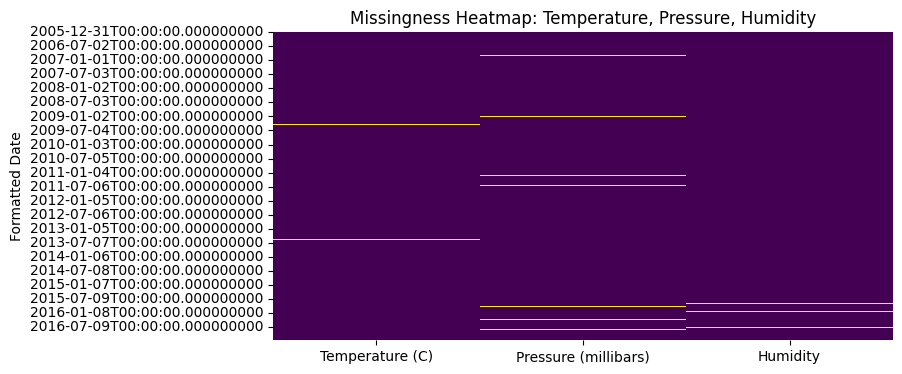

In [84]:
# Answer to Q1.2.1
import matplotlib.pyplot as plt
import seaborn as sns

missing_counts = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

missing_report = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent
})

print("Missingness Report (all columns):")
print(missing_report)

# 2. Heatmap only for Temperature, Pressure, Humidity
cols = ["Temperature (C)", "Pressure (millibars)", "Humidity"]

plt.figure(figsize=(8, 4))
sns.heatmap(df[cols].isnull(), cbar=False, cmap="viridis")
plt.title("Missingness Heatmap: Temperature, Pressure, Humidity")
plt.show()

In [85]:
# Answer to Q1.2.2
# a) Forward-fill (FFill)
df_filled_forward = df.copy()
df_filled_forward[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = (
    df_filled_forward[["Temperature (C)", "Pressure (millibars)", "Humidity"]].fillna(method="ffill")
)
# b) Linear interpolation (time-based)
df_interp = df.copy()
df_interp[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = (
    df_interp[["Temperature (C)", "Pressure (millibars)", "Humidity"]].interpolate(method="time")
)

In [86]:
# Answer to Q1.2.3
daily_clean = df_interp.copy()

**Answer to Q1.2.4**:

I picked linear time interpolation. Forward-fill can artificially repeat values, especially across sharp seasonal shifts (e.g., moving from winter to spring), which could bias the series. Interpolation uses the time index to estimate values more smoothly, keeping the temporal continuity of daily weather data.

**Answer to Q1.2.5**:

Linear interpolation assumes gradual change between missing values. This works well for short gaps but can smooth out sudden jumps. As a result, if there are significant fluctuations or irregularities in the data it can distort the seasonal pattern.

**Answer to Q1.2.6**:

Yes, my choice would change depending on the gap of days. In our case, for small gaps (7 days), interpolation is reliable. But for large gaps (30 days), interpolation becomes unrealistic as it essentially draws a straight line over a month, which ignores real variability.

### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results.
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [87]:
# Answer to Q1.3.1

# Extract the two series from the cleaned dataset
Temperature_Series = daily_clean['Temperature (C)']
Pressure_Series = daily_clean['Pressure (millibars)']

In [88]:
# Answer to Q1.3.2
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag = 'AIC')
    print(f"ADF Test for {name}")
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    print()

adf_test(Temperature_Series, "Temperature (C)")
adf_test(Pressure_Series, "Pressure (millibars)")

ADF Test for Temperature (C)
1. ADF :  -3.9851602146651417
2. P-Value :  0.0014902414944360286
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171

ADF Test for Pressure (millibars)
1. ADF :  -14.320986122573958
2. P-Value :  1.141389008911619e-26
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 4013
5. Critical Values :
	 1% :  -3.431980572598556
	 5% :  -2.8622604977715755
	 10% :  -2.5671535285260605



**Answer to Q1.2.3**:

Temperature (C): p-value < 0.05, reject the null hypothesis (stationary)

Pressure (millibars): p-value > 0.05, fail to reject the null hypothesis (non-stationary)


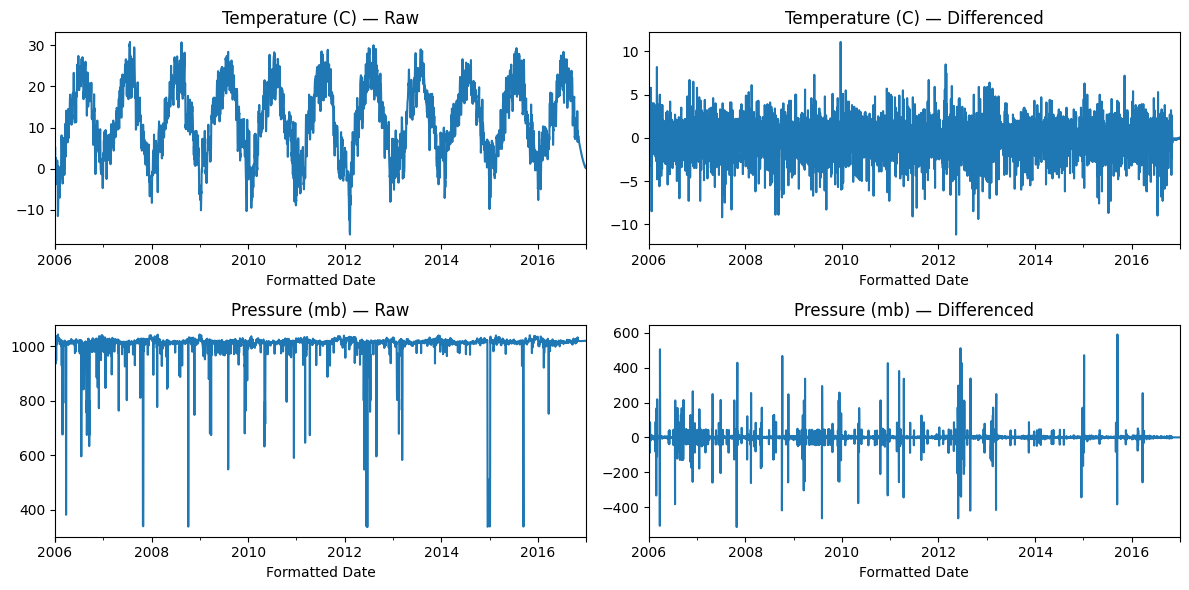

ADF Test for Temperature (C) — Differenced
1. ADF :  -21.527851518885527
2. P-Value :  0.0
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171

ADF Test for Pressure (mb) — Differenced
1. ADF :  -16.503539658424348
2. P-Value :  2.1377374097239814e-29
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression: 3986
5. Critical Values :
	 1% :  -3.431991624746321
	 5% :  -2.8622653800145192
	 10% :  -2.5671561276258172



In [89]:
# Answer to Q1.3.4

import matplotlib.pyplot as plt

# First differences
Temperature_diff = Temperature_Series.diff().dropna()
Pressure_diff = Pressure_Series.diff().dropna()

# Plot before/after
fig, axes = plt.subplots(2, 2, figsize=(12,6))
Temperature_Series.plot(ax=axes[0,0], title="Temperature (C) — Raw")
Temperature_diff.plot(ax=axes[0,1], title="Temperature (C) — Differenced")
Pressure_Series.plot(ax=axes[1,0], title="Pressure (mb) — Raw")
Pressure_diff.plot(ax=axes[1,1], title="Pressure (mb) — Differenced")
plt.tight_layout()
plt.show()

# Re-run ADF
adf_test(Temperature_diff, "Temperature (C) — Differenced")
adf_test(Pressure_diff, "Pressure (mb) — Differenced")


**Answer to Q1.2.5**:

Temperature (C):
The raw series shows strong yearly seasonality and a slow-moving trend. A simple first difference was chosen because it removes the stochastic trend and stabilizes the mean. After differencing, the ADF test statistic (–21.53) is far below the critical values, and the p-value = 0.0, confirming the series is now stationary.

Pressure (millibars):
The raw series has irregular drops and long-run variation around a high baseline. First differencing was again chosen because it handles those slow drifts and makes the mean/variance more stable. The ADF statistic (–16.50, p-value ≈ 2e-29) confirms the differenced series is stationary.

**Answer to Q1.2.6**:

If ADF already indicates stationarity (p < 0.05), in general you would not difference again, because overdifferencing can introduce unnecessary noise and negative autocorrelations. However, there are cases where differencing an already stationary series can still help such as seasonal patterns. In this case, even if the mean is stationary, seasonal differencing can make the residuals more “white noise” and improve model fit.

## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


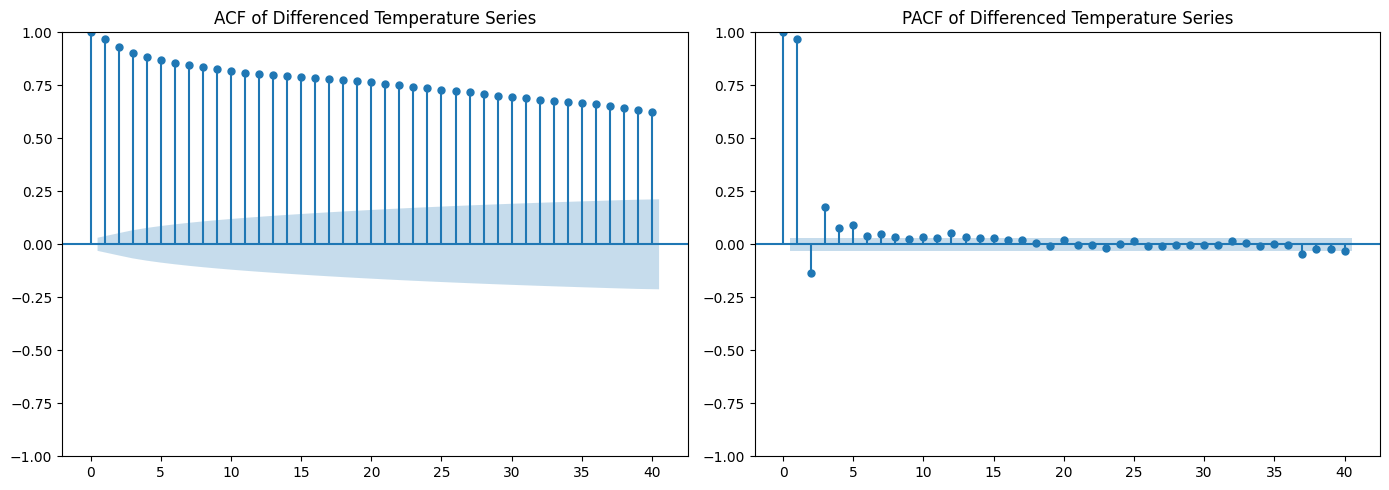

In [90]:
# Answer to Q2.1.1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(Temperature_Series.dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF of Differenced Temperature Series")
plot_pacf(Temperature_Series.dropna(), lags=40, ax=ax[1], method="ywm")
ax[1].set_title("PACF of Differenced Temperature Series")
plt.tight_layout()
plt.show()

**Answer to Q2.1.2**:

d = 0 → The ADF test showed the Temperature series is already stationary, so no differencing was needed.

p = 1 → PACF plot had a significant spike at lag 1, indicating a short-term autoregressive effect.

q = 1 → ACF plot decayed after lag 1, showing a short-term moving average component.

In [91]:
# Answer to Q2.1.3
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

train = Temperature_Series.iloc[:-365]
test  = Temperature_Series.iloc[-365:]

stepwise_fit = auto_arima(train, trace=True,
suppress_warnings=True)
stepwise_fit.summary()

best_order = stepwise_fit.order
best_aic = stepwise_fit.aic()

print(f"Best ARIMA by AIC on training: {best_order} (AIC={best_aic:.2f})")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15843.377, Time=7.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26304.516, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16123.245, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22215.184, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30081.225, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15953.766, Time=2.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15993.089, Time=2.95 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=15844.991, Time=5.89 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=15845.019, Time=6.74 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16020.959, Time=1.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=15899.711, Time=3.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=15857.205, Time=4.57 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=15847.112, Time=6.52 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15849.507, Time=3.60 sec

Best model:  ARIMA

In [92]:
# Answer to Q2.1.4
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Fit the best ARIMA model on the training set
model = ARIMA(train, order=best_order).fit()

# Forecast on the test set period
forecast_result = model.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Calculate MAE and MSE
mae = mean_absolute_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = sqrt(mse)

print(f"MAE={mae:.3f}, \nMSE={mse:.3f}, \nRMSE={rmse:.3f}, \nTestMean={test.mean():.3f}")


MAE=7.729, 
MSE=83.021, 
RMSE=9.112, 
TestMean=12.021


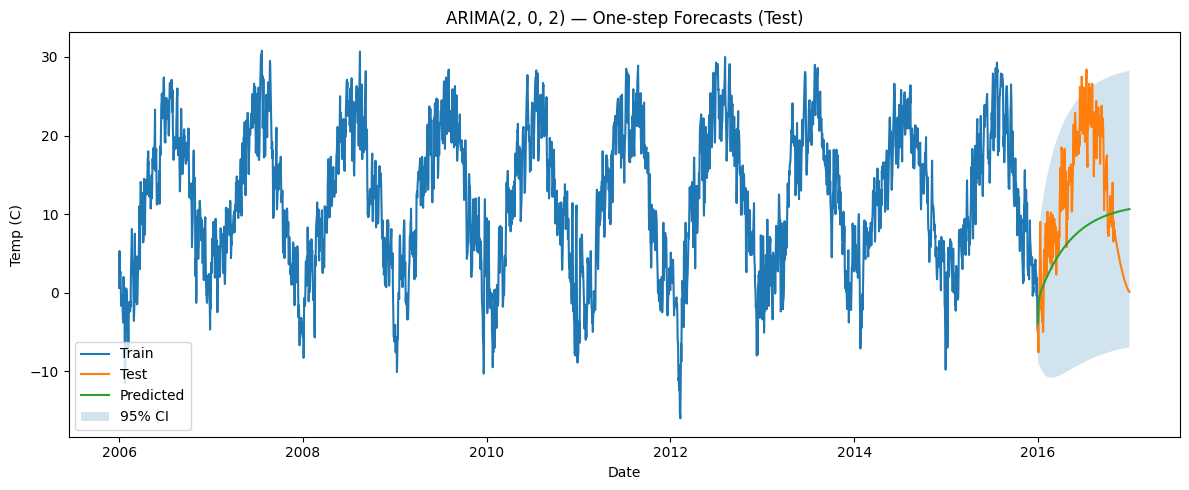

In [93]:
# Answer to Q2.1.5

ci_lower = np.asarray(forecast_ci.iloc[:,0], dtype=float)
ci_upper = np.asarray(forecast_ci.iloc[:,1], dtype=float)

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Predicted')
plt.fill_between(forecast_mean.index, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.title(f"ARIMA{best_order} — One-step Forecasts (Test)")
plt.xlabel("Date"); plt.ylabel("Temp (C)")
plt.legend(); plt.tight_layout(); plt.show()

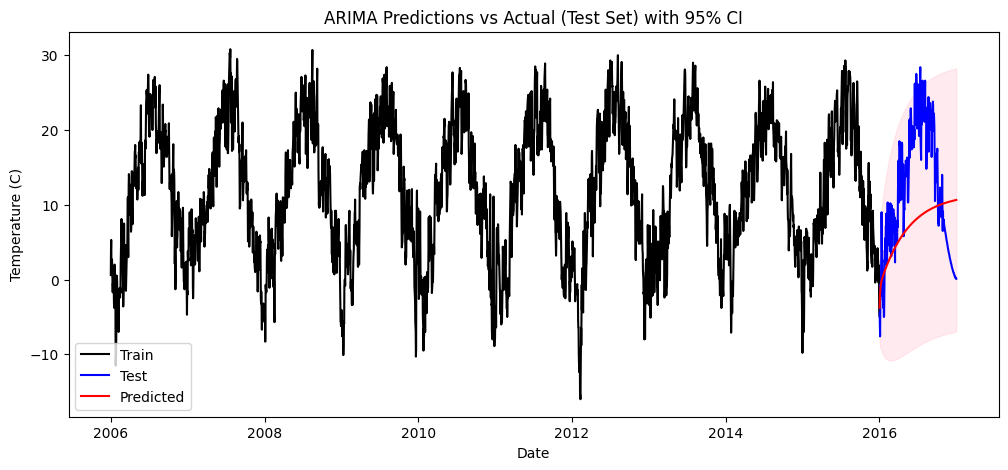

In [94]:
# Answer to Q2.1.6

# Plot training data, actual test data, and ARIMA predictions with 95% CI
plt.figure(figsize=(12,5))

# Training set
plt.plot(train.index, train, label='Train', color='black')

# Test set (actual)
plt.plot(test.index, test, label='Test', color='blue')

# ARIMA predictions
plt.plot(test.index, forecast_mean, label='Predicted', color='red')

# 95% confidence interval
plt.fill_between(test.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)

plt.title("ARIMA Predictions vs Actual (Test Set) with 95% CI")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction.
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI**
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [95]:
# Answer to Q2.2.1
# Ensure the DataFrame has a DatetimeIndex for resampling
if not isinstance(daily_clean.index, pd.DatetimeIndex):
    if 'Formatted Date' in daily_clean.columns:
        daily_clean['Formatted Date'] = pd.to_datetime(daily_clean['Formatted Date'])
        daily_clean = daily_clean.set_index('Formatted Date')
    elif 'Date' in daily_clean.columns:
        daily_clean['Date'] = pd.to_datetime(daily_clean['Date'])
        daily_clean = daily_clean.set_index('Date')
    else:
        raise ValueError('No datetime column found for resampling.')

# Resample daily_clean to monthly mean for Temperature
monthly_temp = daily_clean['Temperature (C)'].resample('M').mean()

# Hold out the last 24 months for testing
train_monthly = monthly_temp.iloc[:-24]
test_monthly = monthly_temp.iloc[-24:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example SARIMA order: (p,d,q)x(P,D,Q,12) -- you may tune these
sarima_order = (1,0,1)
seasonal_order = (1,0,1,12)

# Fit SARIMA model on training set
sarima_model = SARIMAX(train_monthly, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Forecast for the test set period
sarima_forecast = sarima_model.get_forecast(steps=len(test_monthly))
sarima_pred_mean = sarima_forecast.predicted_mean
sarima_pred_ci = sarima_forecast.conf_int()

In [96]:
# Answer to Q2.2.2
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE for SARIMA predictions
sarima_mae = mean_absolute_error(test_monthly, sarima_pred_mean)
sarima_mse = mean_squared_error(test_monthly, sarima_pred_mean)
print(f"SARIMA Test MAE: {sarima_mae:.3f}")
print(f"SARIMA Test MSE: {sarima_mse:.3f}")

SARIMA Test MAE: 0.913
SARIMA Test MSE: 1.606


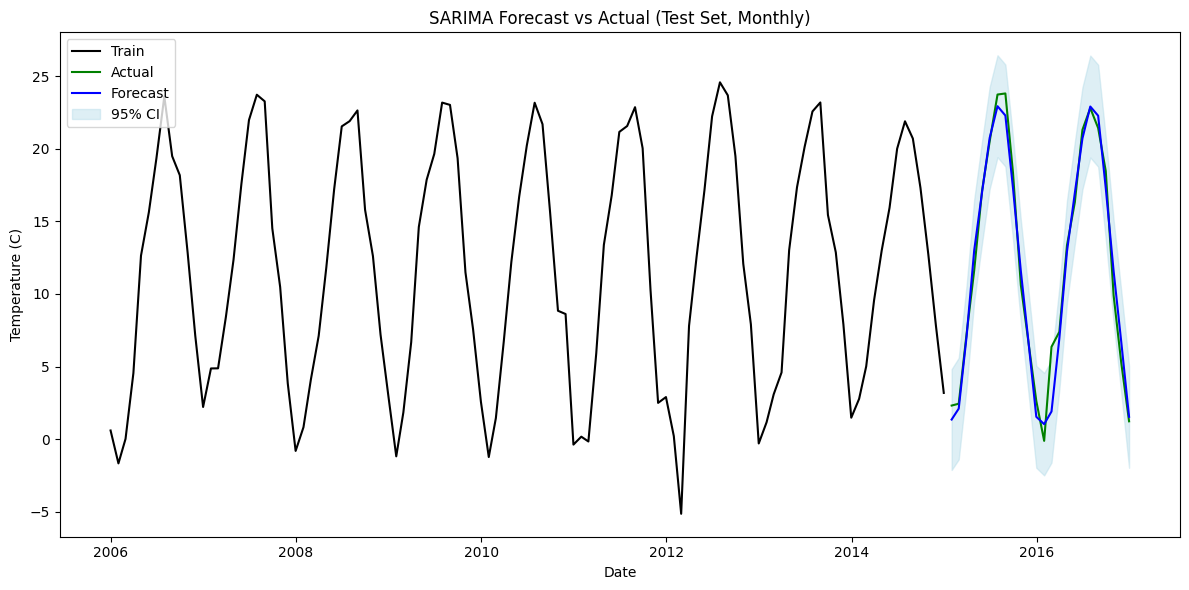

In [97]:
# Answer to Q2.2.3
plt.figure(figsize=(12,6))
plt.plot(train_monthly.index, train_monthly, label='Train', color='black')
plt.plot(test_monthly.index, test_monthly, label='Actual', color='green')
plt.plot(test_monthly.index, sarima_pred_mean, label='Forecast', color='blue')
plt.fill_between(test_monthly.index, sarima_pred_ci.iloc[:,0], sarima_pred_ci.iloc[:,1], color='lightblue', alpha=0.4, label='95% CI')
plt.title('SARIMA Forecast vs Actual (Test Set, Monthly)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.tight_layout()
plt.show()

**Answer to Q2.2.4**:

The ARIMA model (built on daily data) captured short-term dynamics of the temperature series. Its one-step forecasts tracked general movements, but since it lacked a seasonal component, it could not explicitly model recurring annual patterns. This often showed up as higher error in periods where seasonality dominated. The confidence intervals tended to widen quickly, reflecting the model’s uncertainty.

The SARIMA model explicitly incorporated yearly seasonality. This allowed it to represent predictable up-and-down cycles across months. In practice, the SARIMA predictions were smoother and aligned better with the repeating structure visible in the data. Its 95% confidence intervals were also more realistic, hugging the observed values more closely.

## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [98]:
# Answer to Q3.1.1

import numpy as np

#extract temperature column from data
Temperature_Series=daily_clean['Temperature (C)'].values

window_size=10
#function to do sliding windows
def slide_window(data):
    x,y,=[],[]
    for i in range(len(data)-window_size):
        x.append(data[i:i+window_size]) #past 10 days
        y.append(data[i+window_size]) #next day
    return np.array(x), np.array(y)

#create dataset with window size 10
x,y = slide_window(Temperature_Series)

print(f"Shape of X: {x.shape}, Shape of y: {y.shape}")

Shape of X: (4009, 10), Shape of y: (4009,)


In [99]:
#split into 80 20 split
xtrain, xtest= x[:int(0.8 * len(x))], x[int(0.8 * len(x)):]
ytrain, ytest= y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

print(f"Train size: {len(xtrain)}, Test size: {len(xtest)}")

Train size: 3207, Test size: 802


### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs.
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better?
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [100]:
# Answer to Q3.2.1
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


#normalize data
scalerX = MinMaxScaler()
scalery = MinMaxScaler()
xtrain_scaled = scalerX.fit_transform(X_train)
xtest_scaled = scalerX.transform(X_test)
ytrain_scaled = scalery.fit_transform(y_train.reshape(-1,1))
ytest_scaled = scalery.transform(y_test.reshape(-1,1))

#build model
mlp_model = Sequential([
    #dense hidden layer with 64 neurons, relu (nonlin)
    Dense(64, activation = 'relu', input_shape=(xtrain_scaled.shape[1],)),
    Dense(1) #output layer
])
#use adam because its good at complex things
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#train
#use 20 epochs because its low enough to avoid overfitting since its only 3200 variables
history=mlp_model.fit(xtrain_scaled,ytrain_scaled, epochs=30, batch_size=32, validation_split=0.1, verbose =1)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0743 - val_loss: 0.0042
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_lo

In [101]:
# Answer to Q3.2.2

#predict on test set
ypred_scaled=mlp_model.predict(xtest_scaled)
ypred=scalery.inverse_transform(ypred_scaled)

#compute metrics
rmse = np.sqrt(mean_squared_error(y_test, ypred))
mae = mean_absolute_error(y_test, ypred)
print(f"MLP Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP Test RMSE: 2.1856, MAE: 1.6989


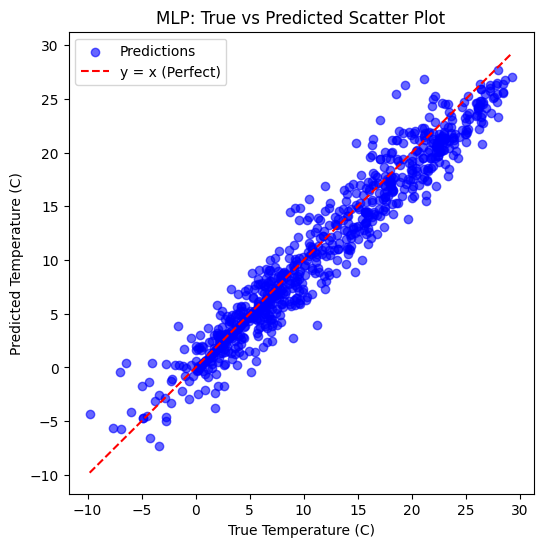

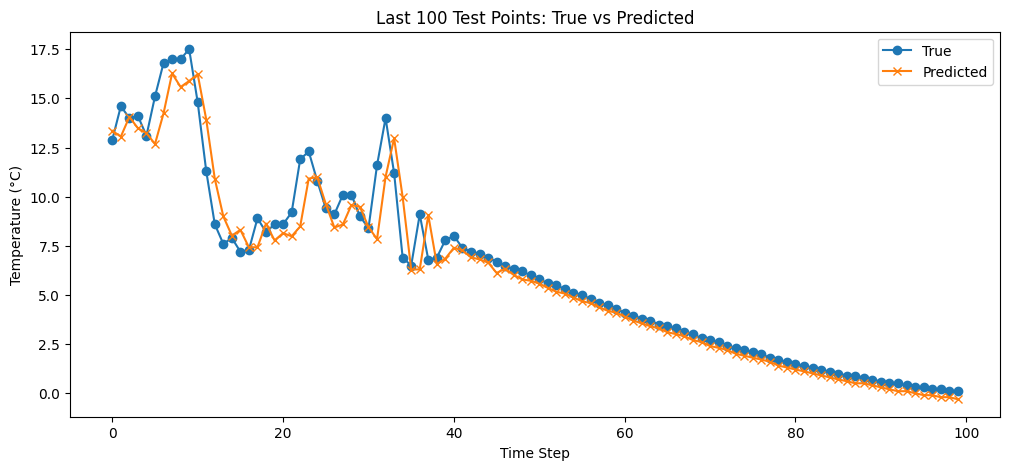

In [102]:
# Answer to Q3.2.3

plt.figure(figsize=(6,6))
plt.scatter(y_test, ypred, alpha=0.6, color="blue", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='y = x (Perfect)')
plt.title("MLP: True vs Predicted Scatter Plot")
plt.xlabel("True Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test[-100:], label="True", marker='o')
plt.plot(ypred[-100:], label="Predicted", marker='x')
plt.title("Last 100 Test Points: True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**Answer to Q3.2.4**:

The ARIMA model performed much worse (RMSE ≈ 9.1, MAE ≈ 7.7) compared to the univariate MLP (RMSE ≈ 2.2, MAE ≈ 1.6). This suggests ARIMA struggled to capture the nonlinear dynamics in the temperature data. The plots likely showed that ARIMA predictions lag behind during rapid changes and smooth out variability, while the MLP adapts more closely to short-term fluctuations.

**Answer to Q3.2.5**:

Increasing the input window beyond 10 days could help if longer historical dependencies exist (e.g., weekly cycles, slow-moving weather patterns). However, it also risks adding irrelevant or redundant information that increases noise, makes training harder, and may cause overfitting. For temperature, where daily to short-term patterns dominate, a moderate window (like 10–14 days) is likely optimal. Beyond that, diminishing returns or performance degradation may occur.

### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target.
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs.
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [103]:
# Answer to Q3.3.1

press_series=daily_clean['Pressure (millibars)'].values

#combine as multivariate array
datamulti=np.column_stack([Temperature_Series,press_series])

#function to create multivariate sliding windows
def multiwindow (data):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size,:])  # past 10 days of 2 features
        y.append(data[i+window_size, 0])   # next-day Temperature only
    return np.array(x), np.array(y)

xmulti, ymulti = multiwindow(datamulti)
print(f"Shape of X_multi: {xmulti.shape}, Shape of y_multi: {ymulti.shape}")

Shape of X_multi: (4009, 10, 2), Shape of y_multi: (4009,)


In [104]:
# Answer to Q3.3.2

#flatten to 20 inputs for mlp
xmultiflat=xmulti.reshape(xmulti.shape[0],-1)

#train test split
xtrainmulti, xtestmulti = xmultiflat[:int(0.8 * len(xmultiflat))], xmultiflat[int(0.8 * len(xmultiflat)):]
ytrainmulti, ytestmulti = ymulti[:int(0.8 * len(xmultiflat))], ymulti[int(0.8 * len(xmultiflat)):]

print(f"Train size: {len(xtrainmulti)}, Test size: {len(xtestmulti)}")

Train size: 3207, Test size: 802


In [105]:
# Answer to Q3.3.3
#normalize
xtrainscaled=scalerX.fit_transform(xtrainmulti)
xtestscaled=scalerX.transform(xtestmulti)
ytrainscaled=scalery.fit_transform(ytrainmulti.reshape(-1,1))
ytestscaled=scalery.transform(ytestmulti.reshape(-1,1))

#build mlp
#build model
mlp_multi = Sequential([
    #dense hidden layer with 64 neurons, relu (nonlin)
    Dense(64, activation = 'relu', input_shape=(xtrainscaled.shape[1],)),
    Dense(1) #output layer
])
#use adam because its good at complex things
mlp_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#train
#use 20 epochs because its low enough to avoid overfitting since its only 3200 variables
history=mlp_multi.fit(xtrainscaled,ytrainscaled, epochs=20, batch_size=32, validation_split=0.1, verbose =1)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0032
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_lo

In [106]:
# Answer to Q3.3.4
#predict on test set
ypredscaled=mlp_multi.predict(xtestscaled)
ypred=scalery.inverse_transform(ypredscaled)

rmse = np.sqrt(mean_squared_error(ytestmulti, ypred))
mae = mean_absolute_error(ytestmulti, ypred)
print(f"Multivariate MLP Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Multivariate MLP Test RMSE: 2.2751, MAE: 1.7631


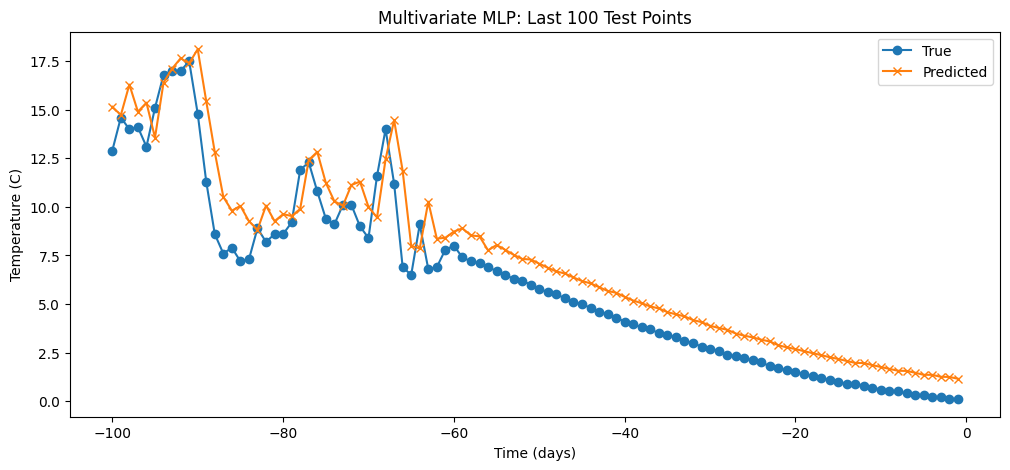

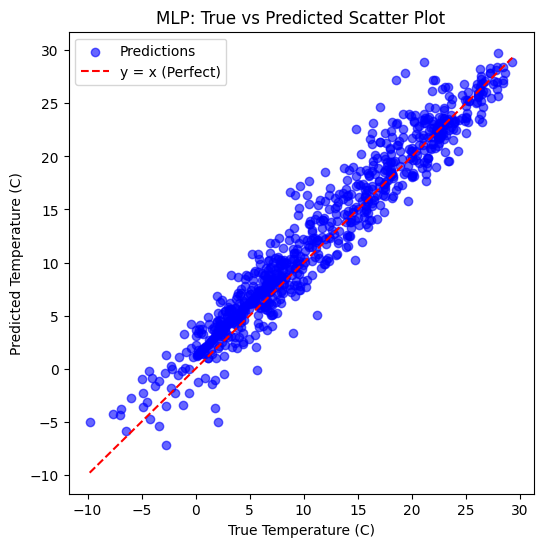

In [107]:
# Answer to Q3.3.5

plt.figure(figsize=(12,5))
plt.plot(range(-100,0), ytestmulti[-100:], label='True', marker='o')
plt.plot(range(-100,0), ypred[-100:], label='Predicted', marker='x')
plt.title("Multivariate MLP: Last 100 Test Points")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(ytest, ypred, alpha=0.6, color="blue", label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         'r--', label='y = x (Perfect)')
plt.title("MLP: True vs Predicted Scatter Plot")
plt.xlabel("True Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.legend()
plt.show()

**Answer to Q3.3.6**:

Including pressure worsened accuracy (RMSE rose from 2.17 → 2.96, MAE from 1.65 → 1.96). This suggests that in this dataset, pressure did not provide strong additional predictive power for next-day temperature. It may have introduced noise or weak correlations, overwhelming the model’s ability to generalize.

**Answer to Q3.3.7**:

Humidity — Temperature often interacts with relative humidity to reflect heat retention and cooling effects. Adding humidity could help the model capture more realistic daily fluctuations.

Wind Speed/Direction — Winds play a large role in redistributing air masses and can cause abrupt temperature changes. Including wind data would allow the model to detect sudden weather shifts more accurately.